In [26]:

import os
import glob
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
from tqdm import tqdm
# from unittest.mock import patch

from lib.utils.io_utils import get_tif_list
from lib.fstack import stack_cyc
from lib.cidre import cidre_correct, cidre_walk
from lib.register import register_meta
from lib.stitch import patch_tiles
from lib.stitch import template_stitch
from lib.stitch import stitch_offset

from lib.register import register_manual
from lib.stitch import stitch_manual
from lib.os_snippets import try_mkdir
    
from skimage.io import imread
# from skimage.io import imsave
from tifffile import imwrite
from skimage.util import img_as_uint

In [27]:
from skimage.transform import resize


def resize_pad(img, size):
    img_resized = resize(img, size, anti_aliasing=True)
    img_padded = np.zeros(img.shape)
    y_start, x_start = (img.shape[0] - size[0]) // 2, (img.shape[1] - size[1]) // 2
    img_padded[y_start:y_start+size[0], x_start:x_start+size[1]] = img_resized
    img_padded = img_as_uint(img_padded)
    return img_padded


def resize_dir(in_dir, out_dir, chn):
    Path(out_dir).mkdir(exist_ok=True)
    chn_sizes = {'cy3': 2302, 'TxRed': 2303, 'FAM': 2301, 'DAPI': 2300}
    size = chn_sizes[chn]
    im_list = list(Path(in_dir).glob(f'*.tif'))
    for im_path in tqdm(im_list, desc=Path(in_dir).name):
        im = imread(im_path)
        im = resize_pad(im, (size, size))
        imwrite(Path(out_dir)/im_path.name, im)#, check_contrast=False)


def resize_batch(in_dir, out_dir):
    try_mkdir(out_dir)
    cyc_paths = list(Path(in_dir).glob('cyc_*_*'))
    for cyc_path in cyc_paths:
        chn = cyc_path.name.split('_')[-1]
        if chn == 'cy5':
            shutil.copytree(cyc_path, Path(out_dir)/cyc_path.name)
        else:
            resize_dir(cyc_path, Path(out_dir)/cyc_path.name, chn)

In [28]:
SRC_DIR = Path(r'F:\spatial_data\raw')
BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20240526_PRISM30_3D_IOH'
src_dir = SRC_DIR / RUN_ID
dest_dir = BASE_DIR / f'{RUN_ID}_processed'

# 2D workflow
aif_dir = dest_dir / 'focal_stacked'
sdc_dir = dest_dir / 'background_corrected'
rgs_dir = dest_dir / 'registered'
stc_dir = dest_dir / 'stitched'
rsz_dir = dest_dir / 'resized'

# 3D workflow
cid_dir = dest_dir / 'cidre'
air_dir = dest_dir / 'airlocalize_stack'

# process2D

In [29]:
def process_2d():
    # raw_cyc_list = list(src_dir.glob('cyc_*'))
    # for cyc in raw_cyc_list:
    #   cyc_num = int(cyc.name.split('_')[1])
    #   stack_cyc(src_dir, aif_dir, cyc_num)

    cidre_walk(str(aif_dir), str(sdc_dir))

    rgs_dir.mkdir(exist_ok=True)
    ref_cyc = 1
    ref_chn = 'cy3'
    ref_chn_1 = 'cy5'
    ref_dir = sdc_dir / f'cyc_{ref_cyc}_{ref_chn}'
    im_names = get_tif_list(ref_dir)

    meta_df = register_meta(str(sdc_dir), str(rgs_dir), ['cy3', 'cy5'], im_names, ref_cyc, ref_chn)
    meta_df.to_csv(rgs_dir / 'integer_offsets.csv')

    # register_manual(rgs_dir/'cyc_1_cy3', sdc_dir/'cyc_1_cy5', rgs_dir/'cyc_1_cy5') #
    register_manual(rgs_dir/'cyc_1_cy3', sdc_dir / 'cyc_1_FAM', rgs_dir/'cyc_1_FAM')
    register_manual(rgs_dir/'cyc_1_cy3', sdc_dir / 'cyc_1_TxRed', rgs_dir/'cyc_1_TxRed')
    register_manual(rgs_dir/'cyc_1_cy3', sdc_dir/'cyc_1_DAPI', rgs_dir/'cyc_1_DAPI')  # 0103 revised! Please remove this !
    
    patch_tiles(rgs_dir/f'cyc_{ref_cyc}_{ref_chn}', 28 * 22)

    resize_batch(rgs_dir, rsz_dir)

    stc_dir.mkdir(exist_ok=True)
    template_stitch(rsz_dir/f'cyc_{ref_cyc}_{ref_chn_1}', stc_dir, 28, 22)
    
    # offset_df = pd.read_csv(rgs_dir / 'integer_offsets.csv', index_col=0)
    # stitch_offset(rgs_dir, stc_dir, offset_df)

# process3D

In [30]:
# Define your per-slice and per-stack programs
def process_slice(slice_2d, channel): 
    if channel != 'cy5':
        # resize and pad the slice
        chn_sizes = {'cy3': 2302, 'txred': 2303, 'fam': 2301, 'dapi': 2300}
        size = chn_sizes[channel]
        slice_2d = resize_pad(slice_2d, (size, size))
    return slice_2d  # Placeholder

# Adjust shift_correction
def shift_correction(signal_df, shift_df, meta_df, tile, cyc, ref_cyc=1):
    adjusted_signals = []
    file = f'FocalStack_{tile:03d}.tif'
    for _, signal_row in signal_df.iterrows():    
        local_x, local_y = signal_row['x_in_pix'], signal_row['y_in_pix']

        # Apply shift if not reference cycle
        if cyc != ref_cyc:
            shift_entry = shift_df.loc[cyc, file]  # Assuming shift_df is indexed by cycle and file
            y_shift, x_shift = map(int, shift_entry.split(' '))
            current_x = local_x + x_shift
            current_y = local_y + y_shift
        else: current_x, currenty = local_x, local_y

        adjusted_signals.append((current_x, current_y))

    xy_adjusted = pd.DataFrame(adjusted_signals, columns=['x_in_pix', 'y_in_pix'])
    signal_df[['x_in_pix', 'y_in_pix']] = xy_adjusted[['x_in_pix', 'y_in_pix']]
    
    return signal_df

def stitch_3d(signal_df, meta_df, tile):
    adjusted_signals = []
    file = f'FocalStack_{tile:03d}.tif'
    # Find the metadata row for this file to get its global position
    for _, signal_row in signal_df.iterrows(): 
        meta_row = meta_df.loc[meta_df['file'] == file].iloc[0]
        local_x, local_y = signal_row['x_in_pix'], signal_row['y_in_pix']
        global_x_start, global_y_start = meta_row['x'], meta_row['y']
        global_x = global_x_start + local_x
        global_y = global_y_start + local_y
        adjusted_signals.append((global_x, global_y))

    xy_adjusted = pd.DataFrame(adjusted_signals, columns=['x_in_pix', 'y_in_pix'])
    signal_df[['x_in_pix', 'y_in_pix']] = xy_adjusted[['x_in_pix', 'y_in_pix']]
    return signal_df

In [31]:
import sys
import re
from collections import defaultdict
# from cv2 import ImwriteFlags
from zmq import CHANNEL

import tifffile
from lib.stitch import read_meta
from lib.AIRLOCALIZE.airlocalize import airlocalize


extract_points_cycle = ['C001']
CHANNELS = ['cy3', 'cy5', 'fam', 'txred']

def process_3d():

    # generate corrected 3d image of each tile
    # cidre_correct(str(src_dir), str(cid_dir))
    stack_name = dict()
    file_groups = defaultdict(list)
    for file_path in glob.glob(os.path.join(src_dir, '*.tif')):
        filename = os.path.basename(file_path)
        parts = filename.split('-')
        cycle, tile, channel = parts[0], parts[1], parts[2]
        z_index = int(filename.split('Z')[-1].split('.')[0])
        file_groups[(cycle, tile, channel)].append((z_index, file_path))
        if tile in stack_name: stack_name[tile].append(cycle)
        else: stack_name[tile] = [cycle]

    stack_name = {key: sorted(value, key=lambda x: int(x[1:])) for key, value in stack_name.items()}
    file_groups = {k: sorted(v) for k, v in file_groups.items()}  # Sort by Z index within each group

    for (cycle, tile, channel), files in tqdm(file_groups.items(), desc='Processing stacks'):
        stack = np.array([process_slice(imread(file_path), channel) for _, file_path in files])
        os.makedirs(air_dir / tile / cycle, exist_ok=True)
        imwrite(air_dir / tile / cycle / f"{channel.lower()}.tif", stack)


    # extract spot candidates from cyc1-4
    for tile in tqdm(stack_name.keys(), desc='Detecting candidate points'):
        for cycle in stack_name[tile]:
            if cycle in extract_points_cycle: 
                tile_cycle_dir = air_dir  / tile / cycle
                # perform airlocalization
                airlocalize(parameters_filename='Image_process/lib/AIRLOCALIZE/parameters.yaml', 
                            default_parameters='Image_process/lib/AIRLOCALIZE/parameters_default.yaml',
                            update={'dataFileName': tile_cycle_dir, 'saveDirName': tile_cycle_dir, 'verbose':False, 'multiChannelCandidates': True})
                
                spots_file = [_ for _ in os.listdir(tile_cycle_dir) if _.endswith('spots.csv')]
                if 'intensity_local.csv' in os.listdir(air_dir/tile):
                    df = pd.read_csv(air_dir / tile / 'intensity_local.csv')
                    df = pd.concat([df] + [pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
                else: df = pd.concat([pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
                df.to_csv(air_dir / tile / 'intensity_local.csv', index=False)


    # multi-channel read
    shift_df = pd.read_csv(rgs_dir / 'integer_offsets.csv', index_col=0)

    for tile in tqdm(stack_name.keys(), desc='Reading spots'):
        combined_candidates = pd.read_csv(air_dir / tile / 'combined_candidates.csv')
        intensity_read = combined_candidates[['z_in_pix', 'x_in_pix', 'y_in_pix']].round().astype(np.uint16).drop_duplicates()
        intensity_read = intensity_read.reset_index()

        for cycle in stack_name[tile]:
            with tifffile.TiffFile(air_dir / tile / 'cy3.tif') as tif:
                shape = tif.series[0].shape

            coordinates = intensity_read[['z_in_pix', 'x_in_pix', 'y_in_pix']]
            coordinates = shift_correction(coordinates, shift_df, cyc=int(cycle[1:]), ref_cyc=1)
            coordinates = coordinates[
                (0 <= coordinates['x_in_pix'] < shape[1]) &
                (0 <= coordinates['y_in_pix'] < shape[2]) &
                (0 <= coordinates['z_in_pix'] < shape[0]) ]
            z_coords = coordinates['z_in_pix'].to_numpy()
            y_coords = coordinates['y_in_pix'].to_numpy()
            x_coords = coordinates['x_in_pix'].to_numpy()

            for channel in CHANNELS:
                image = imread(air_dir/tile/f'{channel}.tif')
                coordinates[f'{cycle}_{channel}'] = image[z_coords, y_coords, x_coords]
                intensity_read['cyc{}_{}'.format(int(cycle[1:]), channel)] = coordinates[f'{cycle}_{channel}']

        intensity_read.to_csv(aif_dir / tile / 'intensity_local.csv')
    

    # stitch the intensity
    meta_df = read_meta(stc_dir)
    pattern = r'\((\d+)\, *(\d+)\)'
    meta_df['match'] = meta_df['position'].apply(lambda x: re.match(pattern, x))
    meta_df['y'] = meta_df['match'].apply(lambda x: int(x.group(2)))
    meta_df['x'] = meta_df['match'].apply(lambda x: int(x.group(1)))
    
    intensity = None
    for tile in tqdm(stack_name.keys(), desc='Stitching'):
        signal_df = pd.read_csv(aif_dir / tile / 'intensity_local.csv')
        if intensity is None: intensity = stitch_3d(signal_df, meta_df, tile)
        else: intensity = pd.concat([intensity, stitch_3d(signal_df, meta_df, tile)])

    intensity.to_csv(air_dir / 'intensity.csv')

# PRISM

In [32]:
tile = 'T0001'
cycle = 'C001'
tile_cycle_dir = air_dir  / tile / cycle / 'raw'
# perform airlocalization
airlocalize(parameters_filename='./lib/AIRLOCALIZE/parameters.yaml', 
            default_parameters='./lib/AIRLOCALIZE/parameters_default.yaml',
            update={'dataFileName': tile_cycle_dir, 'saveDirName': tile_cycle_dir, 'verbose':True, 'multiChannelCandidates': True})

spots_file = [_ for _ in os.listdir(tile_cycle_dir) if _.endswith('spots.csv')]
if 'intensity_local.csv' in os.listdir(air_dir/tile):
    df = pd.read_csv(air_dir / tile / 'intensity_local.csv')
    df = pd.concat([df] + [pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
else: df = pd.concat([pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
df.to_csv(air_dir / tile / 'intensity_local.csv', index=False)

Found 4 files to analyze.
Analyzing file: cy3.tif...
Retrieving image for cy3.tif...
Image scaled from 149.0 to 3030.0
Smoothing cy3.tif, mode: LoG...
Image scaled from -3148.48834206575 to 4917.235327448876
Image scaled from 0.0 to 32767.0
Smoothing cy3.tif done.
Threshold value is 16800.613833969524 in absolute units
Predetected 31548 spots;
Analyzing file: cy5.tif...
Retrieving image for cy5.tif...
Image scaled from 145.0 to 1721.0
Smoothing cy5.tif, mode: LoG...
Image scaled from -2719.1296758705444 to 4617.328871055155
Image scaled from 0.0 to 32767.0
Smoothing cy5.tif done.
Threshold value is 15820.801580484966 in absolute units
Predetected 30174 spots;
Analyzing file: fam.tif...
Retrieving image for fam.tif...
Image scaled from 215.0 to 4643.0
Smoothing fam.tif, mode: LoG...
Image scaled from -2271.1632519175078 to 5087.927356334781
Image scaled from 0.0 to 32767.0
Smoothing fam.tif done.
Threshold value is 14671.726249444875 in absolute units
Predetected 33376 spots;
Analyzing 

Fit predetected spots in cy3.tif: 100%|██████████| 127039/127039 [02:33<00:00, 828.94it/s]


Retrieving image for cy5.tif...
Image scaled from 145.0 to 1721.0


Fit predetected spots in cy5.tif: 100%|██████████| 127039/127039 [02:36<00:00, 813.38it/s]


Retrieving image for fam.tif...
Image scaled from 215.0 to 4643.0


Fit predetected spots in fam.tif: 100%|██████████| 127039/127039 [02:33<00:00, 826.67it/s]


Retrieving image for txred.tif...
Image scaled from 180.0 to 6325.0


Fit predetected spots in txred.tif: 100%|██████████| 127039/127039 [02:36<00:00, 810.05it/s]


In [33]:
from scipy.ndimage import grey_dilation
def generate_image(spots, kernel=np.ones((5, 5, 5), np.uint16), shape=(2302, 2302, 100)):
    image = np.zeros((shape[0], shape[1], shape[2]), dtype=np.uint16)
    z_coords = spots['z_in_pix'].to_numpy().astype(np.uint16)
    y_coords = spots['y_in_pix'].to_numpy().astype(np.uint16)
    x_coords = spots['x_in_pix'].to_numpy().astype(np.uint16)
    image[z_coords, x_coords, y_coords] = spots['integratedIntensity'].to_numpy().astype(np.uint16) / 200
    # dilation of image
    image = grey_dilation(image, footprint=kernel)
    return image


from scipy.spatial import KDTree
def remove_duplicates(coordinates):
    tree = KDTree(coordinates)
    pairs = tree.query_pairs(2)
    # print(f'{len(pairs)} duplicates pairs')
    neighbors = {}  # dictionary of neighbors
    for i, j in pairs:  # iterate over all pairs
        if i not in neighbors: neighbors[i] = set([j])
        else: neighbors[i].add(j)
        if j not in neighbors: neighbors[j] = set([i])
        else: neighbors[j].add(i)

    # print(f'{len(neighbors)} neighbor entries')
    keep = []
    discard = set()  # a list would work, but I use a set for fast member testing with `in`
    nodes = set([s[0] for s in pairs]+[s[1] for s in pairs])
    for node in nodes:
        if node not in discard:  # if node already in discard set: skip
            keep.append(node)  # add node to keep list
            # add node's neighbors to discard set
            discard.update(neighbors.get(node, set()))
    # print(f'{len(discard)} nodes discarded, {len(keep)} nodes kept')
    centroids_simplified = np.delete(coordinates, list(discard), axis=0)
    # print(f'{centroids_simplified.shape[0]} centroids after simplification')
    return centroids_simplified


def read_intensity(image_dict, coordinates):
    intensity = pd.DataFrame({'Z': coordinates[:, 0], 'X': coordinates[:, 1], 'Y': coordinates[:, 2]})
    for image_name, image in image_dict.items():
        intensity[image_name] = image[coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]]
    return intensity


In [34]:
import tifffile as tiff


tile = 'T0001'
cycle = 'C001'

# generate corrected 3d image of each tile
with tiff.TiffFile(air_dir / tile / cycle / 'raw' / f'cy3.tif') as tif: shape = tif.series[0].shape
image_dict = {channel: generate_image(spots=pd.read_csv(
    air_dir / tile / cycle / 'raw' / f'{channel}_spots.csv'), shape=shape) for channel in CHANNELS}

In [40]:
# read intensity
combined_candidates = pd.read_csv(air_dir / tile / cycle / 'raw' / 'spot_candidates.csv')
combined_candidates = combined_candidates.drop_duplicates(subset=['z', 'x', 'y', ])
combined_candidates = combined_candidates[(combined_candidates['z'] >= 0) & (combined_candidates['z'] < shape[0]) &
                                           (combined_candidates['x'] >= 0) & (combined_candidates['x'] < shape[1]) &
                                           (combined_candidates['y'] >= 0) & (combined_candidates['y'] < shape[2])]
print(f'{len(combined_candidates)} candidates before deduplication')

# read intensity
intensity = read_intensity(image_dict, combined_candidates[['z', 'x', 'y']].values)
intensity.to_csv(air_dir / tile / cycle / 'raw' / 'intensity.csv')

113298 candidates before deduplication


In [48]:
intensity = pd.read_csv(air_dir / tile / cycle / 'raw' / 'intensity.csv')
# save original intensity file
intensity = intensity.rename(columns={'cy5': 'R', 'txred': 'Ye', 'cy3': 'G', 'fam': 'B'})

# crosstalk elimination
intensity['B'] = intensity['B'] - intensity['G'] * 0.25
intensity['B'] = np.maximum(intensity['B'], 0)

# Scale
intensity['Scaled_R'] = intensity['R']
intensity['Scaled_Ye'] = intensity['Ye']
intensity['Scaled_G'] = intensity['G'] * 2.5
intensity['Scaled_B'] = intensity['B']

# threshold by intensity
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']

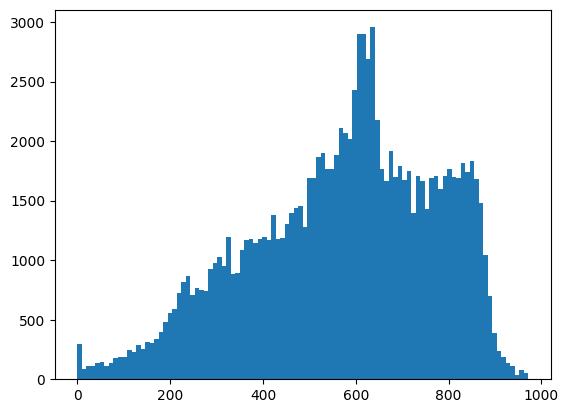

In [49]:
from matplotlib import pyplot as plt
plt.hist(intensity['sum'], bins=100)
plt.show()

In [50]:
SUM_THRESHOLD = 200
intensity = intensity[intensity['sum']>=SUM_THRESHOLD]
print('drop_low_intensity:', len(intensity))

# normalize
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']
intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']

intensity = intensity.dropna()
# intensity.loc[intensity['G/A'] > 5, 'G/A'] = 5
# intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])

drop_low_intensity: 108459


In [51]:
# deduplicate
intensity['ID'] = intensity['Y'] * 10**8 + intensity['X'] * 10**3 + intensity['Z']
intensity = intensity.drop_duplicates(subset=['Y', 'X'])

df = intensity[['Z', 'X', 'Y', 'R', 'Ye', 'B', 'G']]
df_reduced = pd.DataFrame()
coordinates = df[['Z', 'Y', 'X']].values
coordinates = remove_duplicates(coordinates)
df_reduced = pd.DataFrame(coordinates, columns=['Z', 'Y', 'X'])

df_reduced['ID'] = df_reduced['Y'] * 10**8 + df_reduced['X'] * 10**3 + df_reduced['Z']
intensity = intensity[intensity['ID'].isin(df_reduced['ID'])]
intensity = intensity.drop(columns=['ID'])
print('deduplicate:', len(intensity))

deduplicate: 31214


In [52]:
# transform
RYB_x_transform = np.array([[-np.sqrt(2)/2], [0], [np.sqrt(2)/2]])
RYB_y_transform = np.array([[-np.sqrt(3)/3], [2/np.sqrt(3)], [-np.sqrt(3)/3]])
intensity['X_coor'] = intensity[['Ye/A', 'B/A', 'R/A',]] @ RYB_x_transform
intensity['Y_coor'] = intensity[['Ye/A', 'B/A', 'R/A',]] @ RYB_y_transform

intensity.to_csv(air_dir / tile / cycle / 'raw' / 'intensity_deduplicated.csv')

# main

In [7]:
# def main():
#     process_2d()
#     process_3d()

# if __name__ == '__main__':
#     main()

# test

In [14]:
import sys
import re
from collections import defaultdict
from zmq import CHANNEL

import tifffile
from lib.stitch import read_meta
from lib.AIRLOCALIZE.airlocalize import airlocalize

extract_points_cycle = ['C001']
def process_3d():
    # cidre_correct(str(src_dir), str(cid_dir))
    stack_name = dict()
    file_groups = defaultdict(list)
    for file_path in glob.glob(str(src_dir / 'cyc_1_1' / '*.tif')):
        filename = os.path.basename(file_path)
        parts = filename.split('-')
        cycle, tile, channel = parts[0], parts[1], parts[2]
        z_index = int(filename.split('Z')[-1].split('.')[0])
        file_groups[(cycle, tile, channel)].append((z_index, file_path))
        if tile in stack_name: stack_name[tile].add(cycle)
        else: stack_name[tile] = {cycle}

    stack_name = {key: sorted(value, key=lambda x: int(x[1:])) for key, value in stack_name.items()}
    file_groups = {k: sorted(v) for k, v in file_groups.items()}  # Sort by Z index within each group

    for (cycle, tile, channel), files in tqdm(file_groups.items(), desc='Processing stacks'):
        if channel not in CHANNELS: stack = np.array([imread(file_path) for _, file_path in files])
        else: stack = np.array([process_slice(imread(file_path), channel) for _, file_path in files])
        os.makedirs(air_dir / tile / cycle, exist_ok=True)
        imwrite(air_dir / tile / cycle / f"{channel.lower()}.tif", stack)#, check_contrast=False)


    # # extract spot candidates from cyc1-4
    # for tile in tqdm(stack_name.keys(), desc='Detecting candidate points'):
    #     for cycle in stack_name[tile]:
    #         if cycle in extract_points_cycle: 
    #             tile_cycle_dir = air_dir  / tile / cycle
    #             # perform airlocalization
    #             airlocalize(parameters_filename='./lib/AIRLOCALIZE/parameters.yaml', 
    #                         default_parameters='./lib/AIRLOCALIZE/parameters_default.yaml', 
    #                         update={'dataFileName': tile_cycle_dir, 'saveDirName': tile_cycle_dir, 'verbose':True, 'multiChannelCandidates': True})
                
    #             spots_file = [_ for _ in os.listdir(tile_cycle_dir) if _.endswith('spots.csv')]
    #             if 'intensity_local.csv' in os.listdir(air_dir/tile):
    #                 df = pd.read_csv(air_dir / tile / 'intensity_local.csv')
    #                 df = pd.concat([df] + [pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
    #             else: df = pd.concat([pd.read_csv(tile_cycle_dir / file) for file in spots_file], axis=1)
    #             df.to_csv(air_dir / tile / 'intensity_local.csv', index=False)

process_3d()

Processing stacks: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]
